/apps/jupyterhub/2019-04-29/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: read_table is deprecated, use read_csv instead.


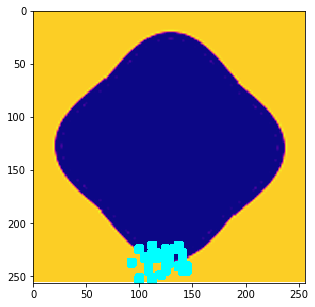

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from scipy.ndimage import gaussian_filter

#%% function definitions

def generate_gabor_filters():
     filters = []                                                                                                            
     ksize = 5 # kernel size
     phi_list = [np.pi/2, np.pi] # phase offset of sinusoid 
     lamda = 5.2 # wavelength of sinusoid 
     theta_list = [0,np.pi/4, np.pi/2, 3*np.pi/4, np.pi] # filter orientation
     b = 1.1 # spatial bandwidth in octaves (will be used to determine SD)
     sigma = lamda*(2**b+1)/np.pi*(2**b-1) * np.sqrt(np.log(2)/2)
     gamma = 0.5 # filter aspect ratio
     for phi in phi_list:
         for theta in theta_list:
             filt = cv2.getGaborKernel((ksize,ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)
             filters.append(filt)
     return filters

def plot_kernel(image, kernels, centre_x, centre_y, filter_num, weight):
    kernel = kernels[filter_num]
    weighted_kernel = 2 * np.array(kernel) #[x * weight for x in kernel]
    if int(np.floor(-len(kernel)/2+centre_x)) >= 0 and int(np.floor(len(kernel)/2+centre_x)) <= 255 and int(np.floor(-len(kernel)/2+centre_y)) >= 0 and int(np.floor(len(kernel)/2+centre_y)) <= 255:
        image[int(np.floor(-len(kernel)/2+centre_x)):int(np.floor(len(kernel)/2+centre_x)),
              int(np.floor(-len(kernel)/2+centre_y)):int(np.floor(len(kernel)/2+centre_y))] = image[int(np.floor(-len(kernel)/2+centre_x)):int(np.floor(len(kernel)/2+centre_x)),
                                                                                                    int(np.floor(-len(kernel)/2+centre_y)):int(np.floor(len(kernel)/2+centre_y))] + weighted_kernel
    return image

# read in data
def read_images(img_dir):
    images = [cv2.imread(file, 0) for file in glob.glob(img_dir+"/*.png")]
    return images
ims = read_images('imgs')
im = ims[11]

# specify neuron to look at
neuron_num = 22
layer = 4

data = pd.read_table(f'weighted_inputs_l{layer}_{neuron_num}.csv' sep=',')
multi_weights =  np.array(data.loc[0])
# multi_weights = [x*10e60 for x in multi_weights]
cent_x = np.array(data.loc[1]).astype(int)
cent_y = np.array(data.loc[2]).astype(int)
filt_n = np.array(data.loc[3]).astype(int)

# crude plot
plt.figure(1,[5,5])
plt.scatter(cent_y,cent_x,marker='s',color='cyan')
plt.xlim([0,256])
plt.ylim([256,0])
plt.imshow(im,cmap='plasma')
norm_weights = multi_weights / np.linalg.norm(multi_weights)

In [2]:
filters = generate_gabor_filters()
empty_image = np.zeros([256,256])
background_weight = 60

# plot kernels
new_image = plot_kernel(empty_image, filters, cent_x[0], cent_y[0], filt_n[0], norm_weights[0])
for i in range(len(cent_x[1:])):
    if multi_weights[i+1] >= 0.005:
        new_image = plot_kernel(new_image, filters, cent_x[i+1], cent_y[i+1], filt_n[i+1], norm_weights[i+1])

# Gaussian filter to smooth RF 
new_image =  gaussian_filter(new_image, sigma=3)

# create final image
background = im != 128
final_image = -(20 * new_image + background_weight * background)

NameError: name 'layer' is not defined

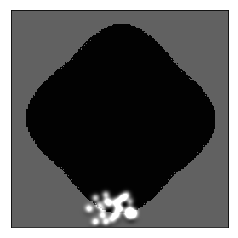

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) # this line adds sub-axes
# plt.scatter(y_locs,x_locs,alpha=0.006,color='k',marker=',')
im = ax.imshow(final_image, cmap='gray',vmax=100) # this line creates the image using the pre-defined sub axes
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
# fig.colorbar(im)
# cbar = fig.colorbar(im)
# cbar.ax.set_yticklabels(['min', 'max'])  # vertically oriented colorbar
plt.savefig(f'l{layer}_{neuron_num}.png',dpi=100)